### Agentic RAG

In [1]:
import os
import warnings
from dotenv import load_dotenv

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
warnings.filterwarnings("ignore")

load_dotenv()

True

In [2]:
from langchain_ollama import ChatOllama

model = "llama3.2:1b"
# model = "qwen2.5"
llm = ChatOllama(model=model, base_url="http://localhost:11434")
print(llm.invoke("Hello, how are you?"))

content="I'm doing well, thank you for asking. I'm a large language model, so I don't have feelings or emotions like humans do, but I'm here and ready to help you with any questions or topics you'd like to discuss. How about you? How's your day going so far?" additional_kwargs={} response_metadata={'model': 'llama3.2:1b', 'created_at': '2025-02-13T09:33:51.162374Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 1574836125, 'load_duration': 571088083, 'prompt_eval_count': 31, 'prompt_eval_duration': 606000000, 'eval_count': 62, 'eval_duration': 396000000} id='run-c27bee96-6a0f-4a8e-be74-aca02695fbd8-0' usage_metadata={'input_tokens': 31, 'output_tokens': 62, 'total_tokens': 93}


### Retriever

In [34]:
from langchain_ollama import OllamaEmbeddings
import faiss
from langchain_community.vectorstores import FAISS 
from langchain_community.docstore.in_memory import InMemoryDocstore


embeddings = OllamaEmbeddings(
    model="nomic-embed-text",
    base_url='http://localhost:11434'
)

db_name = "health_supplements"
vector_store = FAISS.load_local(db_name, embeddings, allow_dangerous_deserialization=True)

retriever = vector_store.as_retriever(search_type="similarity", search_kwargs = {'k': 5})

question = "how to gain muscle mass?"
retriever.invoke(question)

[Document(id='f8a3d7e8-218e-4a2e-9f55-56f98454c7e8', metadata={'producer': 'iLovePDF', 'creator': '', 'creationdate': '', 'source': 'rag-dataset/gym supplements/1. Analysis of Actual Fitness Supplement.pdf', 'file_path': 'rag-dataset/gym supplements/1. Analysis of Actual Fitness Supplement.pdf', 'total_pages': 15, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2024-10-21T11:38:50+00:00', 'trapped': '', 'page': 0}, page_content='individuals increase muscle mass, recover faster, and enhance their overall performance [2].\nWhey protein stands out as a top-quality protein source, containing more essential amino\nacids than traditional protein sources. Its numerous benefits have made it a popular choice\nfor snacks and drinks among consumers [3]. Another widely embraced supplement is\ncaffeine, which is found in many sports and food supplements. Caffeine reduces perceived\neffort, minimizes fatigue and pain, and proves to be effective for enduranc

In [4]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "health_supplements",
    "Search and retrun information about the Health Supplements for workout and gym"
)

tools = [retriever_tool]

In [5]:
tools

[Tool(name='health_supplements', description='Search and retrun information about the Health Supplements for workout and gym', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x1131d7ce0>, retriever=VectorStoreRetriever(tags=['FAISS', 'OllamaEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x117ab5850>, search_kwargs={'k': 5}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x1134fc900>, retriever=VectorStoreRetriever(tags=['FAISS', 'OllamaEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x117ab5850>, search_kwargs={'k': 5}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{pa

### Agent

In [6]:
from typing import Annotated, Sequence, TypedDict, Literal 
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [7]:
from langchain import hub
from langchain_core.messages import  BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from pydantic import BaseModel, Field
from langgraph.prebuilt import tools_condition

### Document Grader

In [17]:
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM with tool and validation
    llm_with_structured_output = llm.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_structured_output

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

### Agent Node

In [18]:
tools

[Tool(name='health_supplements', description='Search and retrun information about the Health Supplements for workout and gym', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x1131d7ce0>, retriever=VectorStoreRetriever(tags=['FAISS', 'OllamaEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x117ab5850>, search_kwargs={'k': 5}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x1134fc900>, retriever=VectorStoreRetriever(tags=['FAISS', 'OllamaEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x117ab5850>, search_kwargs={'k': 5}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{pa

In [27]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]

    llm_with_tools = llm.bind_tools(tools, tool_choice="required")
    response = llm_with_tools.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

### Rewrite Node

In [28]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    response = llm.invoke(msg)
    return {"messages": [response]}

### Generate Node

In [29]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

### Graph

In [30]:
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode

In [31]:
graph_builder = StateGraph(State)

graph_builder.add_node("agent", agent)
retriever = ToolNode([retriever_tool])
graph_builder.add_node("retriever", retriever)
graph_builder.add_node("rewrite", rewrite)

graph_builder.add_node("generate", generate)


graph_builder.add_edge(START, "agent")

graph_builder.add_conditional_edges( 
    "agent",

    tools_condition,
    {
        "tools": "retriever",
        END: END
    }
)

graph_builder.add_conditional_edges(
    "retriever",
    grade_documents
)

graph_builder.add_edge("generate", END)
graph_builder.add_edge("rewrite", "agent")

graph = graph_builder.compile()

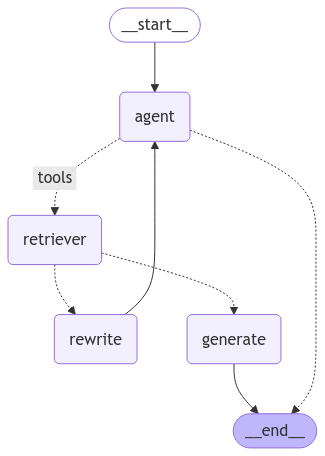

In [32]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
from pprint import pprint

# query = {"messages": [HumanMessage("How to gain muscle mass?")]}
query = {"messages": [HumanMessage("what are the risks of taking too much protein?")]}

# query = {"messages": [HumanMessage("tell me about the langchain")]}

# graph.invoke(query)

for output in graph.stream(query):
    for key, value in output.items():
        pprint(f"Output from node '{key}':")
        pprint("----")
        pprint(value, indent=4, width=120)

    pprint("\n------\n")


---CALL AGENT---
"Output from node 'agent':"
'----'
{   'messages': [   AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:1b', 'created_at': '2025-02-13T10:57:20.931637Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'health_supplements', 'arguments': {'properties': {'query': 'risks of taking too much protein'}, 'required': ['query'], 'type': 'object'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 401876209, 'load_duration': 26304167, 'prompt_eval_count': 177, 'prompt_eval_duration': 114000000, 'eval_count': 40, 'eval_duration': 260000000}, id='run-4ae58e20-52be-4c7d-aacd-5a5c517893a2-0', tool_calls=[{'name': 'health_supplements', 'args': {'properties': {'query': 'risks of taking too much protein'}, 'required': ['query'], 'type': 'object'}, 'id': '36b9859a-c1fa-40cc-adb8-d931467b4898', 'type': 'tool_call'}], usage_metadata={'input_tokens': 177, 'output_tokens': 40, 'total_tokens': 217})]}
'\n------\n'